In [24]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2509'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['C III', 'C IV','O VI']#['Lyalpha', 'Halpha', 'CIII','SiII','SiIII','SiIV','MgII']#['Lyalpha', 'Halpha', 'CIII', 'CIV', 'OVI','SiII','SiIII','SiIV','MgII']  
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""


# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=ions)
    return ds

def scale_by_metallicity(values,assumed_Z,wanted_Z):
    # The Cloudy calculations assumed a single metallicity (typically solar).
    # This function scales the emission by the metallicity of the gas itself to
    # account for this discrepancy.
    wanted_ratio = (10.**(wanted_Z))/(10.**(assumed_Z))
    return values*wanted_ratio

def make_Cloudy_table(table_index):
    # This function takes all of the Cloudy files and compiles them into one table
    # for use in the emission functions
    # table_index is the column in the Cloudy output files that is being read.
    # each table_index value corresponds to a different emission line

    # this is the the range and number of bins for which Cloudy was run
    # i.e. the temperature and hydrogen number densities gridded in the
    # Cloudy run. They must match or the table will be incorrect.
    hden_n_bins, hden_min, hden_max = 15, -5, 2 #17, -6, 2 #23, -9, 2
    T_n_bins, T_min, T_max = 51, 3, 8 #71, 2, 8

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path%(i+1)) if l[0] != "#"]
    return hden,T,table

def make_Cloudy_table_thin(table_index):
    hden_n_bins, hden_min, hden_max = 17, -5, 2
    T_n_bins, T_min, T_max = 51, 3, 8 #71, 2, 8

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path_thin%(i+1)) if l[0] != "#"]
    return hden,T,table


def _Emission_LyAlpha(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_LA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10**dia1) * ((10.0**H_N)**2.0)
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.63e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_HAlpha(field, data, unit_system='default'):
    H_N = np.log10(np.array(data['H_nuclei_density']))
    Temperature = np.log10(np.array(data['Temperature']))
    dia1 = bl_HA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.**dia1) * ((10.**H_N)**2.0)
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 3.03e-12)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_CIII_977(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIII_977(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_CIII_1910(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIII_1910(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_CIV_1548(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIV_1(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.28e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_OVI_1032(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_OVI_1(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.

    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_OVI_1038(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    #dia1 = bl_OVI_1(H_N, Temperature)
    dia2 = bl_OVI_2(H_N, Temperature)
    idx = np.isnan(dia2)
    #dia1[idx] = -200.
    dia2[idx] = -200.
    emission_line = (10**dia2) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))

    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_OVI(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_OVI_1(H_N, Temperature)
    dia2 = bl_OVI_2(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    dia2[idx] = -200.
    emission_line = ((10.0**dia1) + (10**dia2)) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_SiIII_1207(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_SiII_1814(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_SiIV_1394(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_MgII_2796(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11) # what should be instead of 1.65e-11 for MgII? or anyother new element I use?
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def make_fig(ds):
    # Extract the fields: 'Emission_CIV_1548' and 'temperature'
    ad = ds.all_data()

    save_path = prefix + f'emission_temp_plots/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    cmap = mtcm.get_cmap('Set1', 10)  # Colormap for plots
    ion_label_list = ['C III (1910)', 'C IV (1548)', 'O VI (1032 & 1038)']
    # Create a single figure for all histograms
    plt.figure(figsize=(6.4, 4.8))

    for i, (ion, ion_label) in enumerate(zip(ions, ion_label_list)):
        print(ion)

        color = cmap(i)

        # Extract temperature and emission fields
        temperature_field = ad[('gas', 'temperature')]
        emission_field = ad[('gas', 'Emission_' + ions_dict[ion])]

        # Convert fields to numpy arrays for plotting
        temperature_values = temperature_field.v
        emission_values = emission_field.v

        # Filter out invalid data
        valid_indices = (emission_values > 1e-40) & (temperature_values > 1e-40)
        emission_values = emission_values[valid_indices]
        temperature_values = np.log10(temperature_values[valid_indices])

        # Create bins for temperature
        #bins = np.logspace(np.log10(temperature_values.min()), np.log10(temperature_values.max()), 64)
        bins = np.linspace(temperature_values.min(), temperature_values.max(), 64)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # Compute the total emissivity for each temperature bin
        bin_indices = np.digitize(temperature_values, bins)
        emissivity_per_bin = [emission_values[bin_indices == j].sum() for j in range(1, len(bins))]

        # Plot 1D histogram using step plot
        plt.step(bin_centers, emissivity_per_bin, where='mid', color=color, label=f'{ion_label} ')

    # Set up plot scales and labels
    #plt.xscale('log')
    #plt.yscale('log')
    plt.ylim(1e-22, 1e-9)
    plt.xlim(3, 8)
    plt.xlabel('log(Temperature [K])',fontsize=16)
    plt.ylabel('Emissivity [$photon/s/cm^{3}/sr$]',fontsize=16)
    # Adjust tick size
    plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks
    plt.legend()

    # Save and show the single plot
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.1)
    plt.savefig(save_path + f'emission_temp_combined_OVI_linear.png')
    plt.show()
    plt.close()




def load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100):

    '''Loads the simulation snapshot and makes the requested plots, with optional filtering.'''

    # Load simulation output
    snap_name = foggie_dir + snap + '/' + snap
    
    ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)#, smooth_AM_name=smooth_AM_name)
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    add_ion_fields(ds)


    # Generate emission maps based on the plot type
    # if 'emission_map' in plot:
    #     if 'vbins' not in plot:
    #         emission_map(ds, snap, ions, filter_type=filter_type, filter_value=filter_value)
    #     else:
    #         # Call velocity-binned emission map function with optional filtering
    #         emission_map_vbins(ds, snap, ions, unit_system=unit_system, filter_type=filter_type, filter_value=filter_value)
    
    # if 'emission_FRB' in plot:
    #     make_FRB(ds, refine_box, snap, ions, unit_system=unit_system, filter_type=filter_type, filter_value=filter_value, resolution=resolution)
    #     make_mass_FRB(ds, refine_box, snap, ions, filter_type=filter_type, filter_value=filter_value, resolution=resolution)

    

    make_fig(ds)
        

        


    

if __name__ == "__main__":

    
    # if ('feedback' in run) and ('track' in run):
    #     foggie_dir = '/nobackup/jtumlins/halo_008508/feedback-track/'
    #     run_dir = run + '/'
    
    # Set directory for output location, making it if necessary
    prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
    if not (os.path.exists(prefix)): os.system('mkdir -p ' + prefix)
    table_loc = prefix + 'Tables/'

    print('foggie_dir: ', foggie_dir)
    catalog_dir = code_path + 'halo_infos/00' + halo + '/' + run + '/'
    halo_c_v_name = catalog_dir + 'halo_c_v'
    #smooth_AM_name = catalog_dir + 'AM_direction_smoothed'

    cloudy_path = code_path + "emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
    # These are the typical units that Lauren uses
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units = 's**-1 * cm**-3 * steradian**-1'
    ytEmU = unyt.second**-1 * unyt.cm**-3 * unyt.steradian**-1

    # These are a second set of units that a lot of observers prefer
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units_ALT = 'erg * s**-1 * cm**-3 * arcsec**-2'
    ytEmUALT = unyt.erg * unyt.second**-1 * unyt.cm**-3 * unyt.arcsec**-2

    ####################################
    ## BEGIN CREATING EMISSION FIELDS ##
    ####################################

    # To make the emissivity fields, you need to follow a number of steps
    # 1. Read in the Cloudy values for a given emission line
    # 2. Create the n_H and T grids that represent the desired range of values
    # 3. Set up interpolation function for the emissivity values across the grids
    #    so the code can use the n_H and T values of a simulation grid cell to
    #    interpolate the correct emissivity value
    # 4. Define the emission field for the line
    # 5. Add the line as a value in yt

    ############################
    # Function to register emission fields with unit options
    def register_emission_field_with_unit(field_name, function, emission_units, unit_system):
        yt.add_field(
            ('gas', field_name),
            units=emission_units if unit_system == 'default' else emission_units_ALT,
            function=lambda field, data: function(field, data, unit_system=unit_system),
            take_log=True,
            force_override=True,
            sampling_type='cell',
        )
    
    ############################
    # Unit system setting (can be passed dynamically)
    unit_system = 'default'  # Change this to 'ALT' as needed
    
    ############################
    # H-Alpha
    hden_pts, T_pts, table_HA = make_Cloudy_table(2)
    hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
    pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    
    sr_HA = table_HA.T.ravel()
    bl_HA = interpolate.LinearNDInterpolator(pts, sr_HA)
    register_emission_field_with_unit('Emission_HAlpha', _Emission_HAlpha, emission_units, unit_system)
    
    ############################
    # Ly-Alpha
    hden_pts, T_pts, table_LA = make_Cloudy_table(1)
    sr_LA = table_LA.T.ravel()
    bl_LA = interpolate.LinearNDInterpolator(pts, sr_LA)
    register_emission_field_with_unit('Emission_LyAlpha', _Emission_LyAlpha, emission_units, unit_system)
    
    ############################
    # CIII 977
    hden_pts, T_pts, table_CIII_977 = make_Cloudy_table(7)
    sr_CIII_977 = table_CIII_977.T.ravel()
    bl_CIII_977 = interpolate.LinearNDInterpolator(pts, sr_CIII_977)
    register_emission_field_with_unit('Emission_CIII_977', _Emission_CIII_977, emission_units, unit_system)

    ############################
    # CIII 1910
    hden_pts, T_pts, table_CIII_1910 = make_Cloudy_table(9)
    sr_CIII_1910 = table_CIII_1910.T.ravel()
    bl_CIII_1910 = interpolate.LinearNDInterpolator(pts, sr_CIII_1910)
    register_emission_field_with_unit('Emission_CIII_1910', _Emission_CIII_1910, emission_units, unit_system)

    
    ############################
    # CIV 1548
    hden_pts, T_pts, table_CIV_1 = make_Cloudy_table(3)
    sr_CIV_1 = table_CIV_1.T.ravel()
    bl_CIV_1 = interpolate.LinearNDInterpolator(pts, sr_CIV_1)
    register_emission_field_with_unit('Emission_CIV_1548', _Emission_CIV_1548, emission_units, unit_system)
    
    ############################
    # O VI (1032)
    hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
    sr_OVI_1 = table_OVI_1.T.ravel()
    bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    
    register_emission_field_with_unit('Emission_OVI_1032', _Emission_OVI_1032, emission_units, unit_system)

    ############################
    # O VI (1038)
    
    hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
    sr_OVI_2 = table_OVI_2.T.ravel()
    bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
    register_emission_field_with_unit('Emission_OVI_1038', _Emission_OVI_1038, emission_units, unit_system)
    
    ############################
    # O VI (1032 and 1037 combined)
    hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
    hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
    sr_OVI_1 = table_OVI_1.T.ravel()
    sr_OVI_2 = table_OVI_2.T.ravel()
    bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
    register_emission_field_with_unit('Emission_OVI', _Emission_OVI, emission_units, unit_system)
    
    ############################
    # SiIII 1207
    cloudy_path_thin = code_path + "emission/cloudy_z0_HM05/bertone_run%i.dat"
    hden_pts, T_pts, table_SiIII_1207 = make_Cloudy_table_thin(11)
    hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
    pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    sr_SiIII_1207 = table_SiIII_1207.T.ravel()
    bl_SiIII_1207 = interpolate.LinearNDInterpolator(pts, sr_SiIII_1207)
    register_emission_field_with_unit('Emission_SiIII_1207', _Emission_SiIII_1207, emission_units, unit_system)

   


    ############################
    ions_dict = {'Lyalpha':'LyAlpha', 'Halpha':'HAlpha', 'C III':'CIII_1910',
                 'C IV':'CIV_1548','O VI':'OVI', 'Si III':'SiIII_1207'}
    ions_density_dict = {'Lyalpha':'LyAlpha', 'Halpha':'HAlpha', 'C III':'C_p2_density',
                 'C IV':'C_p3_density','O VI':'O_p5_density', 'Si III':'Si_p2_density', 'Si II':'Si_p1_density', 'Si IV':'Si_p3_density','Mg II':'Mg_p1_density'}
    
    label_dict = {'Lyalpha':r'Ly-$\alpha$', 'Halpha':r'H$\alpha$', 'C III':'C III',
                'C IV':'C IV','O VI':'O VI', 'Si III':'Si III'}

    if unit_system  == 'default':
        zlim_dict = {'Lyalpha':[1e-1,1e7], 'Halpha':[1e-1,1e6], 'C III':[1e-4,1e0],
                 'C IV':[1e-2,1e4], 'O VI':[1e-2,1e5], 'Si III':[1e-1,1e4]}
    elif unit_system == 'ALT':
        zlim_dict = {'Lyalpha':[1e-22,1e-16], 'Halpha':[1e-22,1e-16], 'C III':[1e-26,1e-16],
                 'C IV':[1e-23,1e-16], 'O VI':[1e-23,1e-16], 'Si III':[1e-22,1e16]}
        


        






    

foggie_dir:  /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/


yt : [INFO     ] 2024-12-06 11:57:48,213 Parameters: current_time              = 638.06651531954
yt : [INFO     ] 2024-12-06 11:57:48,213 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-06 11:57:48,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-06 11:57:48,214 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-06 11:57:48,214 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-06 11:57:48,214 Parameters: current_redshift          = 0.0021037994044062
yt : [INFO     ] 2024-12-06 11:57:48,215 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2024-12-06 11:57:48,215 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2024-12-06 11:57:48,215 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-12-06 11:57:48,215 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2509/DD2509
get_refine_box: using this location:        col1          col2     col3     col4     col5     col6     col7   col8
------------------ -------- -------- -------- -------- -------- -------- ----
0.0021111231691204 0.488873 0.470349 0.508524 0.490873 0.472349 0.510524    9


Parsing Hierarchy : 100%|██████████| 14472/14472 [00:00<00:00, 19974.22it/s]
yt : [INFO     ] 2024-12-06 11:57:49,575 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985743522644043, 0.47122740745544434, 0.5095312595367432] [unyt_quantity(0.001008, 'code_velocity'), unyt_quantity(-0.00177564, 'code_velocity'), unyt_quantity(0.0011421, 'code_velocity')]


yt : [WARNING  ] 2024-12-06 11:57:57,942 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-06 11:57:57,947 The young_stars3 particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-06 11:57:57,951 The young_stars8 particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-06 11:57:57,956 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-06 11:57:57,960 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-06 11:57:57,964 The dm particle filter already exists. Overriding.


filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector
C III


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_74804/2326457958.py:371: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', 10)  # Colormap for plots


C IV
O VI


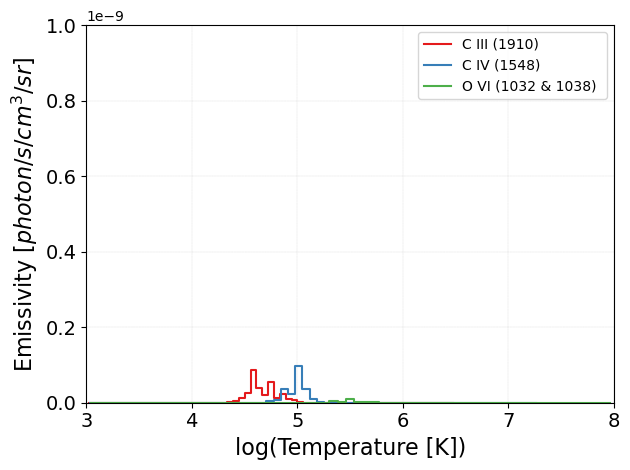

In [25]:
load_and_calculate(snap, ions, unit_system='default', resolution=100) #'default'or choose 'ALT' for erg unit